In [1]:
import numpy as np 
import pandas as pd
import cv2
import os
from tqdm import tqdm
from glob import glob
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D

In [2]:
df = pd.read_csv('driver_detection/driver_imgs_list.csv')
df.head(5)

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [3]:
by_drivers = df.groupby('subject') 
#Group unique drivers
unique_drivers = by_drivers.groups.keys() # drivers id

print('There are : ',len(unique_drivers), ' unique drivers')
print('There is a mean of ',round(df.groupby('subject').count()['classname'].mean()), ' images by driver.')

There are :  26  unique drivers
There is a mean of  862  images by driver.


In [4]:
num_classes = 8

In [5]:
def get_image(path, img_rows, img_cols, color_type=3):
    
    if color_type == 1:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    elif color_type == 3:
        img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (img_rows, img_cols)) # Reduce size
    return img

In [6]:
def train_data_load(img_rows=64, img_cols=64, color_type=3):
    train_images=[]
    train_labels=[]
    
    #Loop over the training folder
    for classes in tqdm(range(num_classes)):
        print('Loading directory c{}'.format(classes))
        files = glob(os.path.join('driver_detection/imgs/train/c' + str(classes), '*.jpg'))
        for file in files:
            img = get_image(file, img_rows, img_cols, color_type)
            train_images.append(img)
            train_labels.append(classes)
    return train_images, train_labels

In [7]:
def read_and_normalize_train_data(img_rows, img_cols, color_type):
    X, labels = train_data_load(img_rows, img_cols, color_type)
    y = np_utils.to_categorical(labels, 8)
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    x_train = np.array(x_train, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    x_test = np.array(x_test, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    
    return x_train, x_test, y_train, y_test

In [8]:
def load_test(size=200000, img_rows=64, img_cols=64, color_type=3):
    path = os.path.join('driver_detection/imgs/test', '*.jpg')
    files = sorted(glob(path))
    X_test, X_test_id = [], []
    total = 0
    files_size = len(files)
    for file in tqdm(files):
        if total >= size or total >= files_size:
            break
        file_base = os.path.basename(file)
        img = get_image(file, img_rows, img_cols, color_type)
        X_test.append(img)
        X_test_id.append(file_base)
        total += 1
    return X_test, X_test_id

In [9]:
def read_and_normalize_sampled_test_data(size, img_rows, img_cols, color_type=3):
    test_data, test_ids = load_test(size, img_rows, img_cols, color_type)   
    test_data = np.array(test_data, dtype=np.uint8)
    test_data = test_data.reshape(-1,img_rows,img_cols,color_type)
    return test_data, test_ids

In [10]:
img_rows = 64
img_cols = 64
color_type = 1
nb_test_samples = 200

#Loading train images 
x_train, x_test, y_train, y_test = read_and_normalize_train_data(img_rows, img_cols, color_type)

#Loading validation images 
test_files, test_targets = read_and_normalize_sampled_test_data(nb_test_samples, img_rows, img_cols, color_type)

  0%|                                                     | 0/8 [00:00<?, ?it/s]

Loading directory c0


 12%|█████▋                                       | 1/8 [00:02<00:19,  2.80s/it]

Loading directory c1


 25%|███████████▎                                 | 2/8 [00:08<00:25,  4.22s/it]

Loading directory c2


 38%|████████████████▉                            | 3/8 [00:13<00:23,  4.68s/it]

Loading directory c3


 50%|██████████████████████▌                      | 4/8 [00:15<00:15,  3.86s/it]

Loading directory c4


 62%|████████████████████████████▏                | 5/8 [00:18<00:10,  3.41s/it]

Loading directory c5


 75%|█████████████████████████████████▊           | 6/8 [00:20<00:06,  3.03s/it]

Loading directory c6


 88%|███████████████████████████████████████▍     | 7/8 [00:22<00:02,  2.75s/it]

Loading directory c7


  0%|                                     | 200/79726 [00:00<01:17, 1024.66it/s]


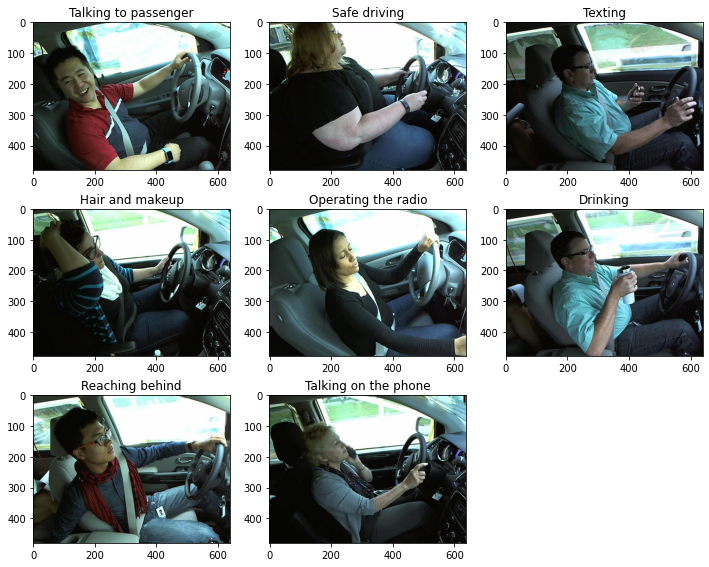

In [15]:
activity_map = {'c0': 'Safe driving', 
                'c1': 'Texting', 
                'c2': 'Talking on the phone', 
                'c3': 'Operating the radio', 
                'c4': 'Drinking', 
                'c5': 'Reaching behind', 
                'c6': 'Hair and makeup', 
                'c7': 'Talking to passenger'}

plt.figure(figsize = (12, 20))
image_count = 1
BASE_URL = 'driver_detection/imgs/train/'
for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(6,3, image_count)
                image_count += 1
                image = mpimg.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(activity_map[directory])

In [20]:
batch_size = 32
n_epochs = 15

In [21]:
def create_model():
    
    model = Sequential()
    
    #CNN1
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=(img_rows, img_cols, color_type)))
    model.add(BatchNormalization())
    model.add(Conv2D(32,(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization(axis=3))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.3))
    
    #CNN2
    model.add(Conv2D(64, (3,3), activation='relu', input_shape=(img_rows, img_cols, color_type)))
    model.add(BatchNormalization())
    model.add(Conv2D(64,(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization(axis=3))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.3))
    
    #CNN3
    model.add(Conv2D(128, (3,3), activation='relu', input_shape=(img_rows, img_cols, color_type)))
    model.add(BatchNormalization())
    model.add(Conv2D(128,(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization(axis=3))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.3))
    
    
    #Output
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(8,activation='softmax'))
    
    
    return model

In [22]:
model = create_model()

#Details about the model
model.summary()

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 62, 62, 32)        320       
                                                                 
 batch_normalization_8 (Batc  (None, 62, 62, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 62, 62, 32)        9248      
                                                                 
 batch_normalization_9 (Batc  (None, 62, 62, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                      

In [23]:
history = model.fit(x_train, y_train,
                   validation_data=(x_test, y_test),
                   epochs=n_epochs, batch_size=batch_size, verbose=1)

print('History of the training',history.history)

Epoch 1/15


2022-05-17 20:16:32.385379: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


491/491 [==============================] - ETA: 0s - loss: 1.1650 - accuracy: 0.6113

2022-05-17 20:16:57.971065: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


491/491 [==============================] - 30s 54ms/step - loss: 1.1650 - accuracy: 0.6113 - val_loss: 0.6215 - val_accuracy: 0.7892
Epoch 2/15
491/491 [==============================] - 26s 52ms/step - loss: 0.2633 - accuracy: 0.9148 - val_loss: 0.1216 - val_accuracy: 0.9655
Epoch 3/15
491/491 [==============================] - 27s 54ms/step - loss: 0.1470 - accuracy: 0.9539 - val_loss: 0.1101 - val_accuracy: 0.9673
Epoch 4/15
491/491 [==============================] - 27s 54ms/step - loss: 0.1035 - accuracy: 0.9683 - val_loss: 0.0628 - val_accuracy: 0.9817
Epoch 5/15
491/491 [==============================] - 25s 51ms/step - loss: 0.0724 - accuracy: 0.9791 - val_loss: 0.3672 - val_accuracy: 0.8891
Epoch 6/15
491/491 [==============================] - 27s 55ms/step - loss: 0.0662 - accuracy: 0.9802 - val_loss: 0.0425 - val_accuracy: 0.9890
Epoch 7/15
491/491 [==============================] - 26s 52ms/step - loss: 0.0469 - accuracy: 0.9855 - val_loss: 0.0802 - val_accuracy: 0.9784
Epo

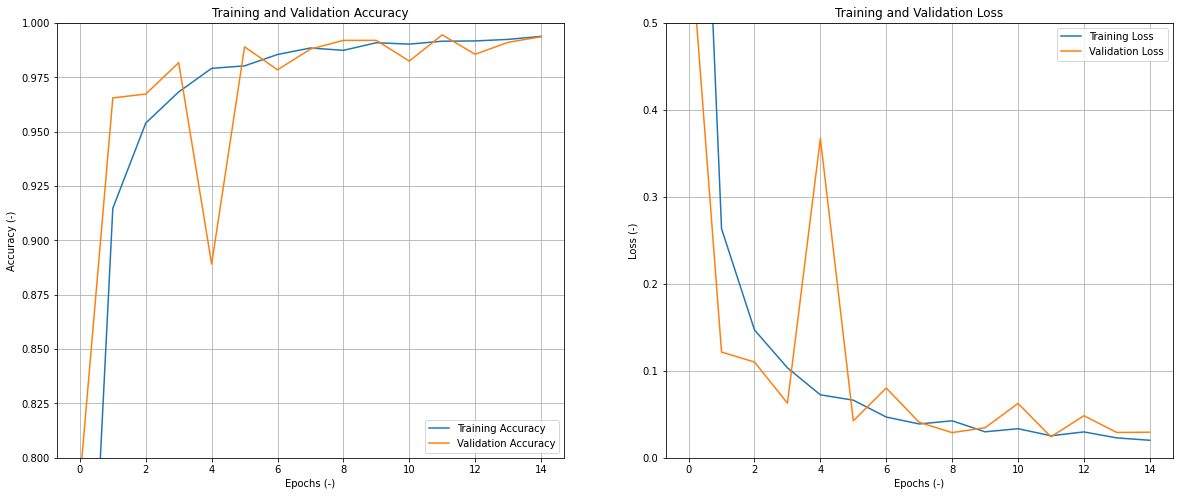

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim((0.8,1))
plt.grid(True)
plt.xlabel("Epochs (-)")
plt.ylabel("Accuracy (-)")
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylim((0.0,0.5))
plt.grid(True)
plt.xlabel("Epochs (-)")
plt.ylabel("Loss (-)")
plt.title('Training and Validation Loss')
plt.show()

In [25]:
def plot_test_class(model, test_files, image_number, color_type=1):
    """
    Function that tests or model on test images and show the results
    """
    img_brute = test_files[image_number]
    img_brute = cv2.resize(img_brute,(img_rows,img_cols))
    plt.imshow(img_brute, cmap='gray')

    new_img = img_brute.reshape(-1,img_rows,img_cols,color_type)

    y_prediction = model.predict(new_img, batch_size=batch_size, verbose=1)
    print('Y prediction: {}'.format(y_prediction))
    print('Predicted: {}'.format(activity_map.get('c{}'.format(np.argmax(y_prediction)))))
    
    plt.show()

In [26]:
score1 = model.evaluate(x_test, y_test, verbose=1)

211/211 [==============================] - 4s 19ms/step - loss: 0.0294 - accuracy: 0.9936


In [27]:
print('Loss: ', score1[0])
print('Accuracy: ', score1[1]*100, '%')

Loss:  0.029446808621287346
Accuracy:  99.36087727546692 %


2022-05-17 20:24:08.824676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 953ms/step
Y prediction: [[2.9951068e-09 1.1792141e-11 8.1741184e-08 9.9999976e-01 8.4886737e-11
  6.0829642e-08 1.7222838e-09 9.4757746e-10]]
Predicted: Operating the radio


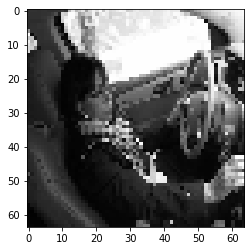

1/1 [==============================] - 0s 14ms/step
Y prediction: [[3.0092715e-06 7.9638248e-08 1.1869465e-05 9.9995196e-01 2.5755595e-05
  6.6791642e-07 5.4562797e-06 1.1413084e-06]]
Predicted: Operating the radio


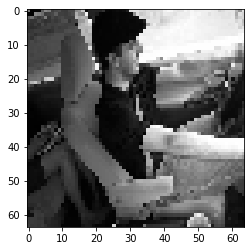

1/1 [==============================] - 0s 15ms/step
Y prediction: [[9.0532380e-01 7.6477848e-02 3.9830697e-03 2.8751733e-06 2.5571615e-04
  1.5408591e-04 1.2157772e-03 1.2586837e-02]]
Predicted: Safe driving


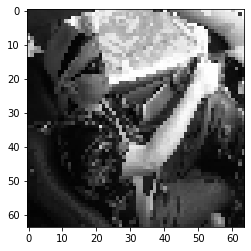

1/1 [==============================] - 0s 29ms/step
Y prediction: [[2.2296842e-04 2.1015285e-07 1.6946173e-03 2.5356871e-05 7.7115592e-06
  2.3611592e-05 9.9785316e-01 1.7245782e-04]]
Predicted: Hair and makeup


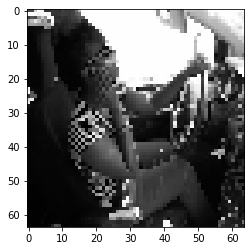

1/1 [==============================] - 0s 16ms/step
Y prediction: [[0.00182719 0.47978818 0.31234035 0.00369783 0.00377012 0.00155493
  0.08111528 0.11590617]]
Predicted: Texting


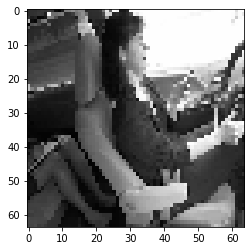

1/1 [==============================] - 0s 15ms/step
Y prediction: [[1.37306722e-06 9.99507427e-01 3.36704488e-06 5.43461065e-05
  1.61360720e-06 2.24402975e-05 1.13990536e-04 2.95421050e-04]]
Predicted: Texting


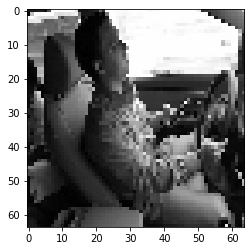

1/1 [==============================] - 0s 20ms/step
Y prediction: [[5.8827263e-05 8.3713305e-01 7.1677862e-04 2.6527424e-03 6.7196455e-04
  1.2809893e-03 8.6597484e-03 1.4882591e-01]]
Predicted: Texting


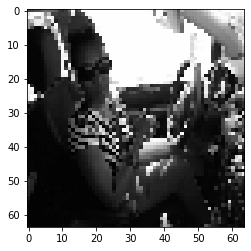

1/1 [==============================] - 0s 11ms/step
Y prediction: [[1.0119901e-04 4.1518454e-02 7.1994369e-03 1.7790037e-04 2.0838319e-04
  4.6068407e-03 9.3559915e-01 1.0588697e-02]]
Predicted: Hair and makeup


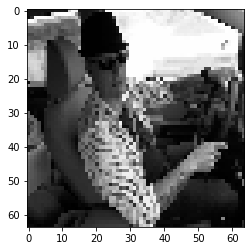

1/1 [==============================] - 0s 14ms/step
Y prediction: [[5.5215247e-07 1.4838620e-09 1.3862187e-05 6.9444121e-07 9.9985027e-01
  1.6300280e-07 1.2719481e-04 7.2461357e-06]]
Predicted: Drinking


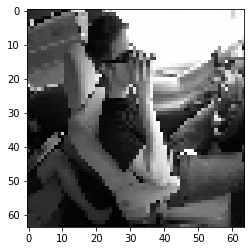

1/1 [==============================] - 0s 12ms/step
Y prediction: [[1.35665825e-08 7.85262273e-08 2.69838107e-08 2.97669800e-07
  1.88761256e-08 9.99999404e-01 4.28834674e-08 6.67598528e-08]]
Predicted: Reaching behind


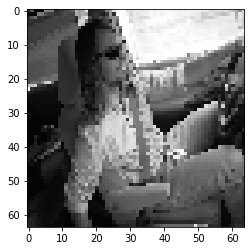

In [29]:
for i in range(10):
    plot_test_class(model, test_files, i)

In [30]:
y_pred = []
y_true = []
a = model.predict(x_test)
for i,j in zip(a,y_test):
    y_pred.append(np.argmax(i))
    y_true.append(np.argmax(j))    

In [31]:
from sklearn.metrics import confusion_matrix
confusMatrx = confusion_matrix(y_true, y_pred)
print(confusMatrx)

[[ 698    0    1    1    0    1    3    1]
 [   5 1414    4    0    0    0    0    0]
 [   0    3 1430    0    0    0    0    0]
 [   1    0    2  688    1    0    0    2]
 [   0    0    3    0  705    0    2    0]
 [   0    0    0    0    1  573    0    0]
 [   1    0    0    0    1    1  572    6]
 [   1    0    0    0    0    0    2  605]]


In [35]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       705
           1       1.00      0.99      1.00      1423
           2       0.99      1.00      1.00      1433
           3       1.00      0.99      0.99       694
           4       1.00      0.99      0.99       710
           5       1.00      1.00      1.00       574
           6       0.99      0.98      0.99       581
           7       0.99      1.00      0.99       608

    accuracy                           0.99      6728
   macro avg       0.99      0.99      0.99      6728
weighted avg       0.99      0.99      0.99      6728



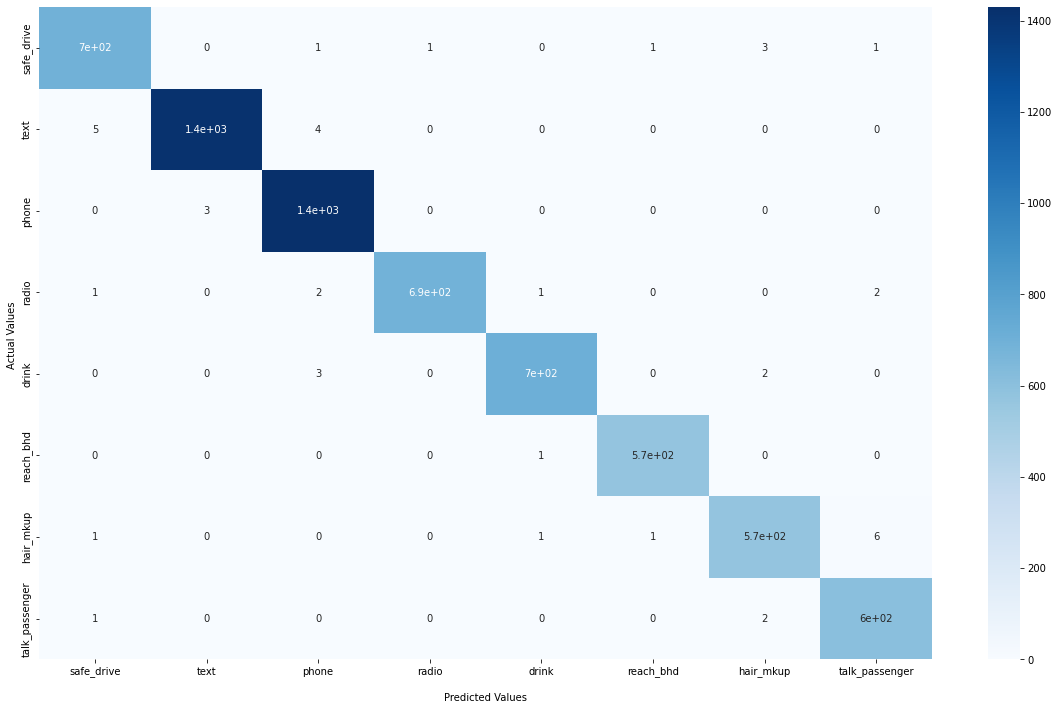

In [32]:
import seaborn as sns
plt.figure(figsize=(20, 12))
ax = sns.heatmap(confusMatrx, annot=True, cmap='Blues')

ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['safe_drive', 'text', 'phone', 'radio', 'drink', 'reach_bhd', 'hair_mkup', 'talk_passenger'])
ax.yaxis.set_ticklabels(['safe_drive', 'text', 'phone', 'radio', 'drink', 'reach_bhd', 'hair_mkup', 'talk_passenger'])

plt.show()